In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
import scipy.stats as st
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'



In [2]:
run ../util/setupConsole

In [3]:
# low and high temps for gdd/kdd calcs, taken from Butler, et al, 2015, ERL
t_low = 9
t_high = 29

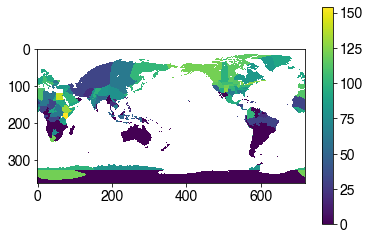

In [96]:
# load the sacks crop calendars

sacksMaizeStart = np.genfromtxt('%s/sacks/sacks-planting-end-Maize.txt'%dataDirDiscovery, delimiter=',')
sacksMaizeStart[sacksMaizeStart<0] = np.nan
sacksMaizeEnd = np.genfromtxt('%s/sacks/sacks-harvest-start-Maize.txt'%dataDirDiscovery, delimiter=',')
sacksMaizeEnd[sacksMaizeEnd<0] = np.nan

sacksMaizeStart = np.roll(sacksMaizeStart, int(sacksMaizeStart.shape[1]/2), axis=1)
sacksMaizeEnd = np.roll(sacksMaizeEnd, int(sacksMaizeEnd.shape[1]/2), axis=1)

plt.figure(); plt.imshow(np.clip(sacksMaizeEnd-sacksMaizeStart, 0, 200)); plt.colorbar()

In [ ]:
# calculate gdd/kdd from cpc temperature data

if os.path.isfile('%s/kdd-cpc.dat'%dataDirDiscovery) and os.path.isfile('%s/gdd-cpc.dat'%dataDirDiscovery):
    with gzip.open('%s/kdd-cpc.dat'%dataDirDiscovery, 'rb') as f:
        kdd = pickle.load(f)

    with gzip.open('%s/gdd-cpc.dat'%dataDirDiscovery, 'rb') as f:
        gdd = pickle.load(f)
    
    with gzip.open('%s/gdd-kdd-lat-cpc.dat'%dataDirDiscovery, 'rb') as f:
        lat = pickle.load(f)
    
    with gzip.open('%s/gdd-kdd-lon-cpc.dat'%dataDirDiscovery, 'rb') as f:
        lon = pickle.load(f)
else:
    gdd = np.zeros([360, 720, len(range(1981, 2011+1))])
    kdd = np.zeros([360, 720, len(range(1981, 2011+1))])

    for y, year in enumerate(range(1981, 2011+1)):
        print('processing year %d...'%year)

        dsMax = xr.open_dataset('/dartfs-hpc/rc/lab/C/CMIG/CPC/tmax/tmax.%d.nc'%year, decode_cf=False)
        dsMax.load()

        dims = dsMax.dims
        startingDate = datetime.datetime(1900, 1, 1, 0, 0, 0)
        tDt = []

        for curTTime in dsMax.time:
            delta = datetime.timedelta(hours=int(curTTime.values))
            tDt.append(startingDate + delta)
        dsMax['time'] = tDt

        dsMin = xr.open_dataset('/dartfs-hpc/rc/lab/C/CMIG/CPC/tmin/tmin.%d.nc'%year, decode_cf=False)
        dsMin.load()

        dims = dsMin.dims
        startingDate = datetime.datetime(1900, 1, 1, 0, 0, 0)
        tDt = []

        for curTTime in dsMin.time:
            delta = datetime.timedelta(hours=int(curTTime.values))
            tDt.append(startingDate + delta)
        dsMin['time'] = tDt

        for xlat in range(len(dsMax.lat)):
            for ylon in range(len(dsMax.lon)):
                if ~np.isnan(sacksMaizeStart[xlat,ylon]) and ~np.isnan(sacksMaizeEnd[xlat,ylon]):
                    curTmax = dsMax.tmax[int(sacksMaizeStart[xlat, ylon]):int(sacksMaizeEnd[xlat, ylon]), xlat, ylon]
                    curTmin = dsMin.tmin[int(sacksMaizeStart[xlat, ylon]):int(sacksMaizeEnd[xlat, ylon]), xlat, ylon]

                    curYearGdd = (curTmax.where(curTmax > t_low) + curTmin.where(curTmin > t_low))/2-t_low
                    curYearGdd = curYearGdd.sum(dim='time')

                    gdd[xlat, ylon, y] = curYearGdd.values

                    curYearKdd = curTmax.where(curTmax > t_high)-t_high
                    curYearKdd = curYearKdd.sum(dim='time')

                    kdd[xlat, ylon, y] = curYearKdd.values

processing year 1981...


In [32]:
with gzip.open('%s/kdd-cpc.dat'%dataDirDiscovery, 'wb') as f:
    pickle.dump(kdd, f)

with gzip.open('%s/gdd-cpc.dat'%dataDirDiscovery, 'wb') as f:
    pickle.dump(gdd, f)

with gzip.open('%s/gdd-kdd-lat-cpc.dat'%dataDirDiscovery, 'wb') as f:
    pickle.dump(dsMax.lat.values, f)

with gzip.open('%s/gdd-kdd-lon-cpc.dat'%dataDirDiscovery, 'wb') as f:
    pickle.dump(dsMax.lon.values, f)

In [19]:
# calculate gdd and kdd trends from already-loaded cpc tmax and tmin data

gddTrends = np.zeros([360, 720])
kddTrends = np.zeros([360, 720])

for x in range(gddTrends.shape[0]):
    for y in range(gddTrends.shape[1]):
        X = sm.add_constant(range(gdd.shape[2]))
        mdl = sm.OLS(gdd[x, y, :], X).fit()
        gddTrends[x, y] = mdl.params[1]
        
        X = sm.add_constant(range(kdd.shape[2]))
        mdl = sm.OLS(kdd[x, y, :], X).fit()
        kddTrends[x, y] = mdl.params[1]

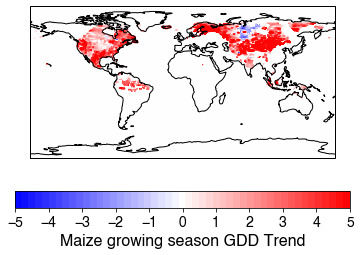

In [42]:
cRange=[-5, 5]
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(gddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 1))
cbar.set_label('Maize growing season GDD Trend')
ax.coastlines()

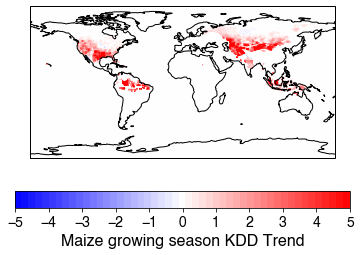

In [43]:
cRange=[-5, 5]
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(kddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 1))
cbar.set_label('Maize growing season KDD Trend')
ax.coastlines()

In [8]:
# load crop yield trends from iizumi data

maize = np.zeros([360, 720, len(range(1981, 2011+1))])
maizeTrends = np.full([360, 720], np.nan)

rice = np.zeros([360, 720, len(range(1981, 2011+1))])
riceTrends = np.full([360, 720], np.nan)

soybean = np.zeros([360, 720, len(range(1981, 2011+1))])
soybeanTrends = np.full([360, 720], np.nan)

wheat = np.zeros([360, 720, len(range(1981, 2011+1))])
wheatTrends = np.full([360, 720], np.nan)

for year in range(1981, 2011+1):
    maizeNc = xr.open_dataset('%s/iizumi/maize/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    maizeNc.load()
    maizeNc = maizeNc.rename({'var':'maize_yield'})
    maize[:, :, year-1981] = np.flipud(maizeNc.maize_yield.values)
    
    soybeanNc = xr.open_dataset('%s/iizumi/soybean/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    soybeanNc.load()
    soybeanNc = soybeanNc.rename({'var':'soybean_yield'})
    soybean[:, :, year-1981] = np.flipud(soybeanNc.soybean_yield.values)
    
    riceNc = xr.open_dataset('%s/iizumi/rice/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    riceNc.load()
    riceNc = riceNc.rename({'var':'rice_yield'})
    rice[:, :, year-1981] = np.flipud(riceNc.rice_yield.values)
    
    wheatNc = xr.open_dataset('%s/iizumi/wheat/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    wheatNc.load()
    wheatNc = wheatNc.rename({'var':'wheat_yield'})
    wheat[:, :, year-1981] = np.flipud(wheatNc.wheat_yield.values)

maize[maize < 0] = np.nan
soybean[soybean < 0] = np.nan
rice[rice < 0] = np.nan
wheat[wheat < 0] = np.nan


In [9]:
# calculate trends in crop yields

for xlat in range(maize.shape[0]):
    if xlat%50 == 0: print('%.1f%% complete'%(xlat/maize.shape[0]*100))
    for ylon in range(maize.shape[1]):

        nn = np.where(~np.isnan(maize[xlat, ylon, :]))[0]
        if nn.shape[0] == maize.shape[2]:
            X = sm.add_constant(range(maize.shape[2]))
            mdl = sm.OLS(maize[xlat, ylon, :], X).fit()
            maizeTrends[xlat, ylon] = mdl.params[1]
        
        nn = np.where(~np.isnan(soybean[xlat, ylon, :]))[0]
        if nn.shape[0] == soybean.shape[2]:
            X = sm.add_constant(range(soybean.shape[2]))
            mdl = sm.OLS(soybean[xlat, ylon, :], X).fit()
            soybeanTrends[xlat, ylon] = mdl.params[1]
            
        nn = np.where(~np.isnan(rice[xlat, ylon, :]))[0]
        if nn.shape[0] == rice.shape[2]:
            X = sm.add_constant(range(rice.shape[2]))
            mdl = sm.OLS(rice[xlat, ylon, :], X).fit()
            riceTrends[xlat, ylon] = mdl.params[1]
            
        nn = np.where(~np.isnan(wheat[xlat, ylon, :]))[0]
        if nn.shape[0] == wheat.shape[2]:
            X = sm.add_constant(range(wheat.shape[2]))
            mdl = sm.OLS(wheat[xlat, ylon, :], X).fit()
            wheatTrends[xlat, ylon] = mdl.params[1]

0.0% complete
13.9% complete
27.8% complete
41.7% complete
55.6% complete
69.4% complete
83.3% complete
97.2% complete


In [10]:
kddTrend1d = np.reshape(kddTrends, [kddTrends.size])
kddTrend1dNorm = kddTrend1d/np.linalg.norm(kddTrend1d)
gddTrend1d = np.reshape(gddTrends, [gddTrends.size])
gddTrend1dNorm = gddTrend1d/np.linalg.norm(gddTrend1d)

maizeTrend1d = np.reshape(maizeTrends, [maizeTrends.size])

(array([3.50000e+01, 2.94000e+02, 1.33200e+03, 2.29852e+05, 1.85050e+04,
        6.65200e+03, 1.91200e+03, 4.43000e+02, 1.05000e+02, 7.00000e+01]),
 array([-30.70323821, -22.7934316 , -14.88362499,  -6.97381838,
          0.93598823,   8.84579484,  16.75560145,  24.66540807,
         32.57521468,  40.48502129,  48.3948279 ]),
 <a list of 10 Patch objects>)

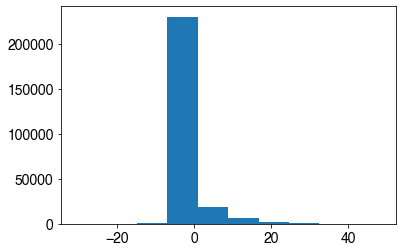

In [11]:
plt.hist(kddTrend1d)

In [12]:
maizeMean1d = np.reshape(np.nanmean(maize, axis=2), [maize.shape[0]*maize.shape[1]])
prc50 = np.nanpercentile(maizeMean1d,50)
maizeIndAbove50p = np.where((maizeMean1d > prc50) & (~np.isnan(maizeTrend1d)) & (~np.isnan(kddTrend1d)))[0]
maizeIndBelow50p = np.where((maizeMean1d < prc50) & (~np.isnan(maizeTrend1d)) & (~np.isnan(kddTrend1d)))[0]

In [13]:
X = sm.add_constant(maizeTrend1d[maizeIndBelow50p])
mdl = sm.RLM(kddTrend1dNorm[maizeIndBelow50p], X).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                 3024
Model:                            RLM   Df Residuals:                     3022
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 07 Feb 2020                                         
Time:                        18:55:57                                         
No. Iterations:                    18                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   8.98e-05      4.477      0.000       0.000       0.001
x1             0.0380      0.003     11.654      0.000       0.032       0.044
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [14]:
X = sm.add_constant(maizeTrend1d[maizeIndAbove50p])
mdl = sm.RLM(kddTrend1dNorm[maizeIndAbove50p], X).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                 2117
Model:                            RLM   Df Residuals:                     2115
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 07 Feb 2020                                         
Time:                        18:55:57                                         
No. Iterations:                    21                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010   7.86e-05     12.719      0.000       0.001       0.001
x1            -0.0023      0.001     -3.287      0.001      -0.004      -0.001
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [16]:
print(kddTrend1d.shape)
print(maizeMean1d.shape)

(259200,)
(259200,)


In [20]:
nn = np.where((~np.isnan(maizeMean1d)) & (~np.isnan(kddTrend1d)))[0]

bins = np.arange(0, 25, 3)
binMeans = np.zeros(bins.shape)

for b in range(len(bins)-1):
    binMeans[b] = np.nanmean(kddTrend1d[np.where((maizeMean1d >= bins[b]) & (maizeMean1d < bins[b+1]))])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     187.3
Date:                Fri, 07 Feb 2020   Prob (F-statistic):           2.22e-42
Time:                        19:00:21   Log-Likelihood:                -55998.
No. Observations:               15118   AIC:                         1.120e+05
Df Residuals:                   15116   BIC:                         1.120e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6679      0.114     84.918      0.000       9.445       9.891
x1            -0.3164      0.023    -13.685      0.000      -0.362      -0.271
==============================================================================
Omnibus:                     1764.222   Durbin-Watson:                   0.295
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6560.022
Skew:                           0.557   Prob(JB):                         0.00
Kurtosis:                       6.028   Cond. No.                         7.16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

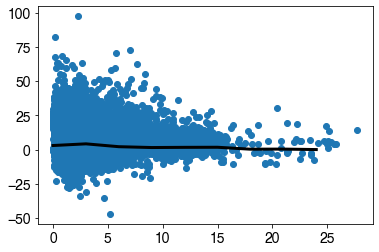

In [22]:
plt.figure()
plt.scatter(maizeMean1d[nn], gddTrend1d[nn])
plt.plot(bins, binMeans, '-k', lw=3)

X = sm.add_constant(maizeMean1d[nn])
mdl = sm.OLS(gddTrend1d[nn], X).fit()
mdl.summary()

In [ ]:
3+3